In [10]:
%pip install pandas numpy matplotlib seaborn scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
df_red = pd.read_csv("winequality-red.csv", sep=';', quotechar='"')
df_white = pd.read_csv("winequality-white.csv", sep=';', quotechar='"')

# Show the first few rows of each
# df_red.head()
# df_white.head()


In [13]:
df_red['type'] = 'red'
df_white['type'] = 'white'

In [14]:
print("Red Wine:")
print(df_red.info())
print(df_red.isnull().sum())

Red Wine:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
 12  type                  1599 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 162.5+ KB
None
fixed acidity           0
volatile acidity      

In [15]:
print("\nWhite Wine:")
print(df_white.info())
print(df_white.isnull().sum())



White Wine:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
 12  type                  4898 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 497.6+ KB
None
fixed acidity           0
volatile acidity   

Red wine quality levels: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
White wine quality levels: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]


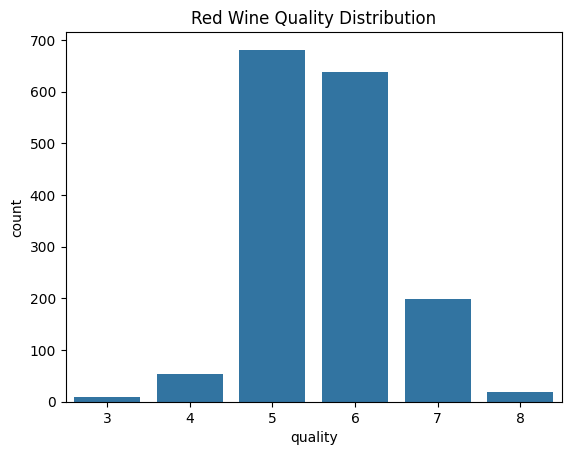

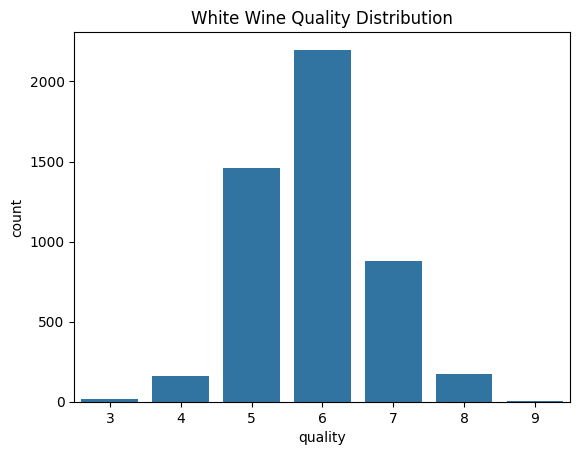

In [30]:
# Check unique quality scores
print("Red wine quality levels:", sorted(df_red['quality'].unique()))
print("White wine quality levels:", sorted(df_white['quality'].unique()))

# Plot distribution of quality
sns.countplot(x='quality', data=df_red)
plt.title("Red Wine Quality Distribution")
plt.show()

sns.countplot(x='quality', data=df_white)
plt.title("White Wine Quality Distribution")
plt.show()


In [31]:
# Categorize wine quality
def map_quality(value):
    if value <= 4:
        return "Low"
    elif value <= 6:
        return "Standard"
    else:
        return "High"

# Apply only to red wine dataset here
df_red['quality_label'] = df_red['quality'].apply(map_quality)
df_white['quality_label'] = df_white['quality'].apply(map_quality)

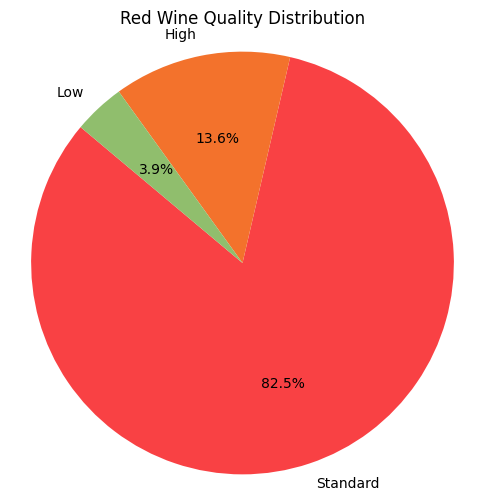

In [18]:
import matplotlib.pyplot as plt

# Count each category
label_counts = df_red['quality_label'].value_counts()

# Plot
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=['#f94144','#f3722c','#90be6d'])
plt.title('Red Wine Quality Distribution')
plt.axis('equal')  # Equal aspect ratio makes the pie round
plt.show()


In [19]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
from collections import Counter

In [32]:
def split_data(df, test_size):
    X = df.drop(columns=['quality', 'quality_label'])
    y = df['quality_label']
    
    return train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)


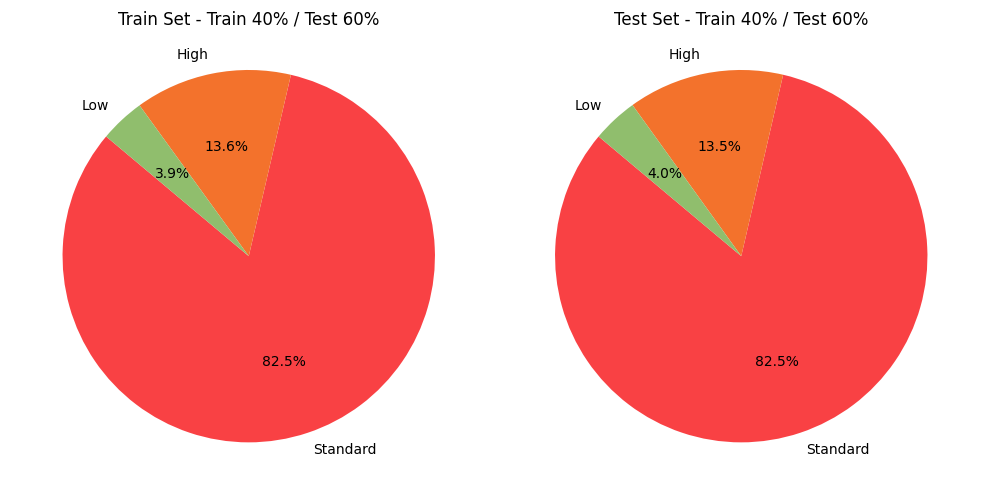

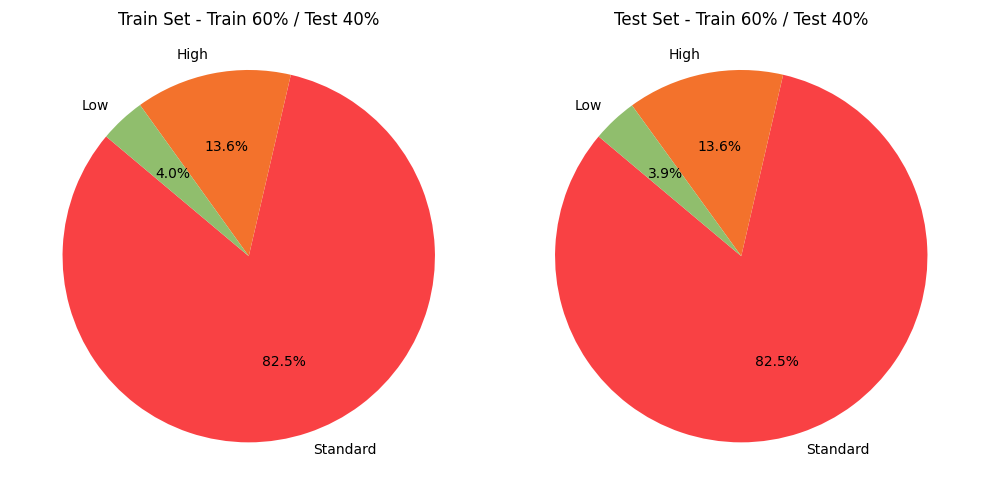

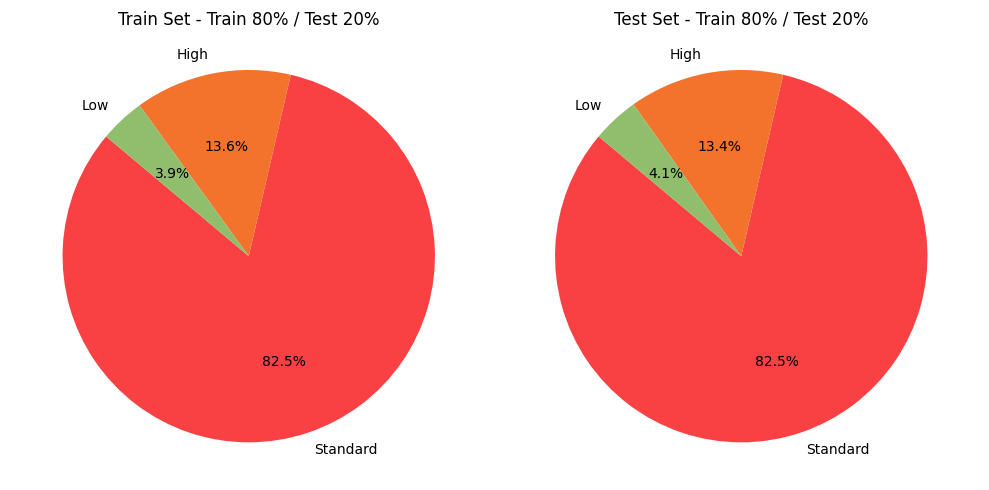

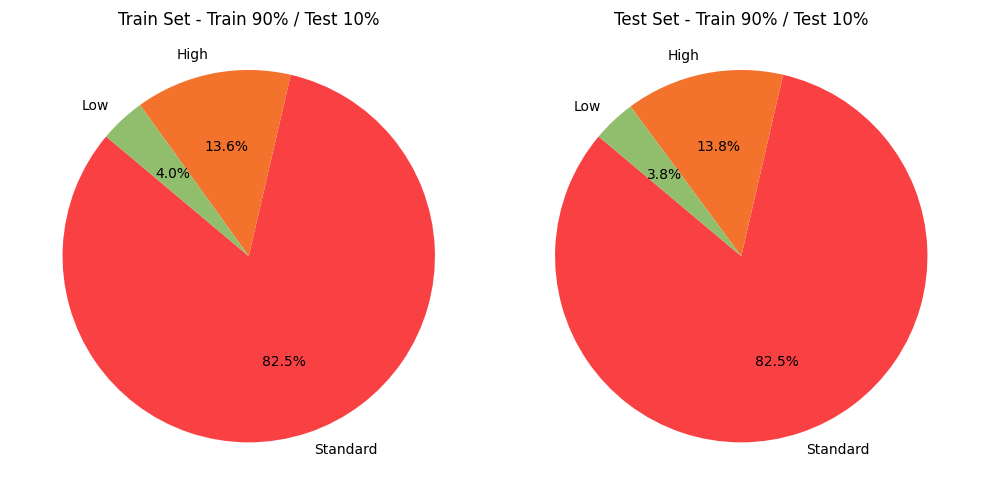

In [33]:
# Define split ratios
splits = [0.6, 0.4, 0.2, 0.1]  # These are test sizes (40/60 → 0.6, etc.)
titles = ["Train 40% / Test 60%", "Train 60% / Test 40%", "Train 80% / Test 20%", "Train 90% / Test 10%"]

# Loop through each split
for i, test_size in enumerate(splits):
    X_train, X_test, y_train, y_test = split_data(df_red, test_size=test_size)
    
    # Count labels
    train_counts = y_train.value_counts()
    test_counts = y_test.value_counts()

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].pie(train_counts, labels=train_counts.index, autopct='%1.1f%%',
                startangle=140, colors=['#f94144','#f3722c','#90be6d'])
    axes[0].set_title(f"Train Set - {titles[i]}")
    axes[0].axis('equal')

    axes[1].pie(test_counts, labels=test_counts.index, autopct='%1.1f%%',
                startangle=140, colors=['#f94144','#f3722c','#90be6d'])
    axes[1].set_title(f"Test Set - {titles[i]}")
    axes[1].axis('equal')

    plt.tight_layout()
    plt.show()


In [26]:
%pip install graphviz pydotplus

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [27]:
# Build a Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import graphviz
from IPython.display import Image
import pydotplus
from sklearn.tree import plot_tree


In [28]:
def train_and_visualize_tree(X_train, X_test, y_train, y_test, max_depth=None, split_name=""):
    # Initialize classifier
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=42)
    
    # Train
    clf.fit(X_train, y_train)

    # Predict
    y_pred = clf.predict(X_test)

    # Report
    print(f"--- Results for {split_name} ---")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    # Visualize using plot_tree (simpler)
    plt.figure(figsize=(20,10))
    plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=np.unique(y_train).astype(str))
    plt.title(f"Decision Tree - {split_name}")
    plt.show()


In [29]:
splits = {
    "40/60": (
        data_splits["40-60"]["feature_train"], 
        data_splits["40-60"]["feature_test"], 
        data_splits["40-60"]["label_train"], 
        data_splits["40-60"]["label_test"]
    ),
    "60/40": (
        data_splits["60-40"]["feature_train"], 
        data_splits["60-40"]["feature_test"], 
        data_splits["60-40"]["label_train"], 
        data_splits["60-40"]["label_test"]
    ),
    "80/20": (
        data_splits["80-20"]["feature_train"], 
        data_splits["80-20"]["feature_test"], 
        data_splits["80-20"]["label_train"], 
        data_splits["80-20"]["label_test"]
    ),
    "90/10": (
        data_splits["90-10"]["feature_train"], 
        data_splits["90-10"]["feature_test"], 
        data_splits["90-10"]["label_train"], 
        data_splits["90-10"]["label_test"]
    ),
}
